<a href="https://colab.research.google.com/github/Muun-Muun/clusterd_sattelites_optimization/blob/main/impulse_CA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm
from matplotlib.patches import Ellipse

In [3]:
# ---------------------- 함수 정의 ----------------------
def cw_propagate(delta_v, n, t_array):
    """CW 방정식 기반 상대 위치 궤적 계산"""
    x0 = np.zeros((6,))
    x0[3:] = delta_v
    positions = []

    for t in t_array:
        nt = n * t
        cos_nt, sin_nt = np.cos(nt), np.sin(nt)
        x = (4 - 3 * cos_nt) * x0[0] + sin_nt / n * x0[3] + 2 * (1 - cos_nt) / n * x0[4]
        y = 6 * (sin_nt - nt) * x0[0] + x0[1] + 2 * (cos_nt - 1) / n * x0[3] + (4 * sin_nt - 3 * nt) / n * x0[4]
        z = cos_nt * x0[2] + sin_nt / n * x0[5]
        positions.append([x, y, z])

    return np.array(positions)


def get_max_impact_delta_v(A, delta_v_max):
    ATA = A.T @ A
    eigvals, eigvecs = eig(ATA)
    v_opt = eigvecs[:, np.argmax(eigvals)]
    return v_opt / norm(v_opt) * delta_v_max


def get_min_pc_delta_v(cov, delta_v_max):
    eigvals, eigvecs = eig(cov)
    v_dir = eigvecs[:, np.argmin(eigvals)]
    v_dir = v_dir / norm(v_dir) * delta_v_max
    return np.array([v_dir[0], v_dir[1], 0.0])


def plot_covariance_ellipse(cov, ax, n_std=1.0, edgecolor='blue', **kwargs):
    """공분산 타원 그리기"""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                      edgecolor=edgecolor, facecolor='none', **kwargs)
    ax.add_patch(ellipse)



In [27]:
# ---------------------- 초기 설정 ----------------------
n = 0.0011  # 평균 운동량 [rad/s]
delta_v_max = 0.0001  # Δv 제약 [km/s]
T = 2 * np.pi / n  # 한 궤도 주기 [s]
t_vals = np.linspace(0, 3*T, 1000)  # 3궤도주기

# Δv → 위치 변화 행렬 예시
A = np.array([
    [0.5, 0.1, 0.0],
    [0.0, 0.3, 0.2]
])

# 공분산 행렬 예시 (b-plane 상)
covariance = np.array([
    [0.005, 0.003],
    [0.003, 0.010]
])

In [28]:
# ---------------------- Δv 계산 ----------------------
v_max_impact = get_max_impact_delta_v(A, delta_v_max)
v_min_pc = get_min_pc_delta_v(covariance, delta_v_max)

traj_max = cw_propagate(v_max_impact, n, t_vals)
traj_min = cw_propagate(v_min_pc, n, t_vals)

(np.float64(0.0001), np.float64(0.0001))

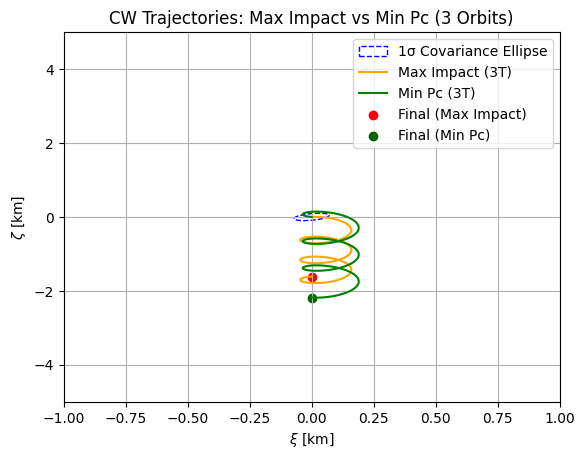

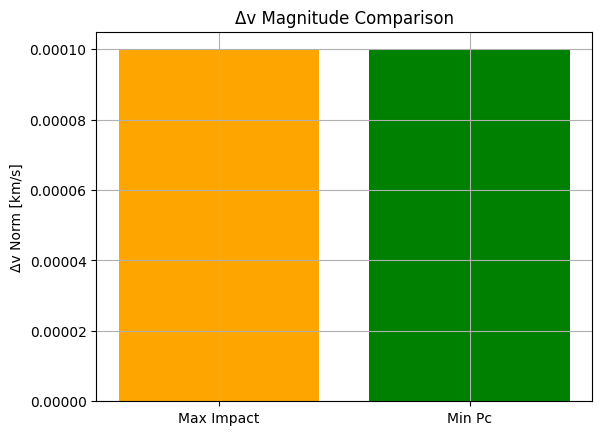

In [31]:


# ---------------------- 플롯 1: 궤적 ----------------------
fig1, ax1 = plt.subplots()
plot_covariance_ellipse(covariance, ax1, edgecolor='blue', linestyle='--', label='1σ Covariance Ellipse')

ax1.plot(traj_max[:, 0], traj_max[:, 1], label='Max Impact (3T)', color='orange')
ax1.plot(traj_min[:, 0], traj_min[:, 1], label='Min Pc (3T)', color='green')
ax1.scatter(traj_max[-1, 0], traj_max[-1, 1], color='red', label='Final (Max Impact)')
ax1.scatter(traj_min[-1, 0], traj_min[-1, 1], color='darkgreen', label='Final (Min Pc)')
ax1.set_xlabel(r'$\xi$ [km]')
ax1.set_ylabel(r'$\zeta$ [km]')
ax1.set_xlim(-1,1)
ax1.set_ylim(-5,5)
ax1.set_title('CW Trajectories: Max Impact vs Min Pc (3 Orbits)')
ax1.grid(True)
ax1.legend()

# ---------------------- 플롯 2: Δv norm ----------------------
fig2, ax2 = plt.subplots()
norms = [norm(v_max_impact), norm(v_min_pc)]
ax2.bar(['Max Impact', 'Min Pc'], norms, color=['orange', 'green'])
ax2.set_ylabel('Δv Norm [km/s]')
ax2.set_title('Δv Magnitude Comparison')
ax2.grid(True)

norm(v_max_impact), norm(v_min_pc)